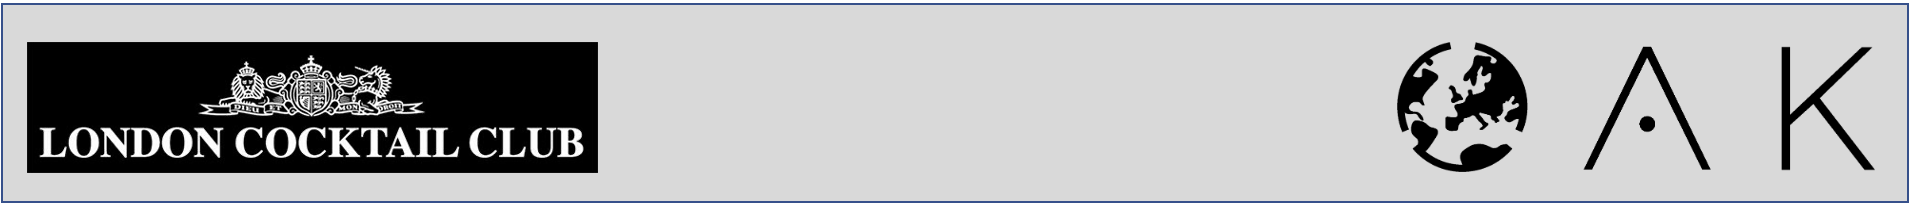

In [1]:
import IPython
IPython.display.Image("combine.png")

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%run Alert_Framework_Summary.ipynb

import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import warnings
warnings.filterwarnings('ignore')
from appscript import app, k
from mactypes import Alias
from pathlib import Path
from datetime import datetime,timedelta

import pandas as pd
pd.set_option('display.precision',3)

from datetime import datetime
import numpy as np
from datetime import timedelta

from IPython.display import display,Javascript,Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import FileLink, FileLinks , HTML

from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
%matplotlib inline
display(HTML("<style>.container {width:100% !important;}</style>"))
import warnings
warnings.simplefilter("ignore")
import pdb;

import seaborn as sns

from tabulate import tabulate



def create_message_with_attachment(time):
    subject = 'Alert Notification'
    body = 'The variable is higher than the thresholds @ '+str(time)+ ' for more than 50 min.'
    to_recip = ['avinash@oak-network.com', 'jyoti@oak-network.com','deba@oak-network.com']

    msg = Message(subject=subject, body=body, to_recip=to_recip)
    msg.send()
    msg.show()

class Outlook(object):
    def __init__(self):
        self.client = app('Microsoft Outlook')

class Message(object):
    def __init__(self, parent=None, subject='', body='', to_recip=[], cc_recip=[], show_=True):

        if parent is None: parent = Outlook()
        client = parent.client

        self.msg = client.make(
            new=k.outgoing_message,
            with_properties={k.subject: subject, k.content: body})

        self.add_recipients(emails=to_recip, type_='to')
        self.add_recipients(emails=cc_recip, type_='cc')

        if show_: self.show()

    def show(self):
        self.msg.open()
        self.msg.activate()
    def send(self):
        self.msg.send()

    def add_attachment(self, p):
        p = Alias(str(p)) # convert string/path obj to POSIX/mactypes path
        attach = self.msg.make(new=k.attachment, with_properties={k.file: p})

    def add_recipients(self, emails, type_='to'):
        if not isinstance(emails, list): emails = [emails]
        for email in emails:
            self.add_recipient(email=email, type_=type_)

    def add_recipient(self, email, type_='to'):
        msg = self.msg
        if type_ == 'to':
            recipient = k.to_recipient
        elif type_ == 'cc':
            recipient = k.cc_recipient
        msg.make(new=recipient, with_properties={k.email_address: {k.address: email}})

def generate_graph(df,variable,name_of_the_variable):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=df['Time stamp'], y=df[variable], name=name_of_the_variable),secondary_y=False)
    fig.add_trace(go.Scatter(x=df['Time stamp'], y=df['Threshold'], name="Threshold"),secondary_y=False)
    fig.add_trace(go.Scatter(x=df['Time stamp'], y=df['Flag'], name="Flag",text=df["alert text"],textposition="bottom center"\
                   ,mode='lines+markers+text',marker=dict(color=df['color_marker']),line=dict(color='#00FE35')),secondary_y=True)
    fig.update_layout(title_text="<b>Alert Generation Graph</b>",title_x=0.5)
    fig.update_yaxes(title_text="<b>"+ name_of_the_variable +"</b> ", secondary_y=False)
    fig.update_yaxes(title_text="<b>Alert</b>", secondary_y=True)
    fig.show()
    return 

# Alerts Generation

def generate_alert_report(df,variable,threshold,name_of_the_variable,case,obs_count):
    start=datetime.datetime.now()
#     print("Alert Report Generation Starts @ "+ str(start))
    df['Flag']=0
    if case=="greater":
        df.loc[df[variable]>threshold,'Flag']=1  
    else:
        df.loc[df[variable]<threshold,'Flag']=1  
    df['Alert Log']="No Alert"
    count=0
    add=[]
    z=0
    
    for i in range(obs_count,df['Flag'].shape[0]):
        j=i-obs_count
        while j< i:
            if df['Flag'][i]>=df['Flag'][j] & df['Flag'][i]!=0:
                count+=1
                if count>obs_count and ((df['Alert Log'][i-1]!="Alert") and (df['Alert Log'][i-2]!="Alert")):
                    z+=1
                    add.append(df['Time stamp'][i])
                    df['Alert Log'].iloc[i]="Alert"
                    if z==1:
                        abc=1
    #                     create_message_with_attachment(df['Time stamp'][i])
                    break
                    count=6
            else:
                break
            j+=1


    add=list(set(add))
    len(add)

    print("Total Number of Alerts:" + str(len(add)))

    df['color_marker']=np.where(df['Alert Log']=="Alert", 'red', '#00FE35')
    df['Threshold']=threshold

    df['alert text']=np.where(df['Alert Log']=="Alert","Alert","")
    
    generate_graph(df,variable,name_of_the_variable)
    
    print("Alert Report Generation Ends @ "+ str(datetime.datetime.now()))
    print("************************************************************************************")
    return df

def generate_alert_report(df,variable,threshold,name_of_the_variable,case,obs_count):
    start=datetime.now()
#     print("Alert Report Generation Starts @ "+ str(start))
#     df['Time stamp']=df['Time stamp'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    df=df.sort_values("Time stamp")
    df.reset_index(drop=True,inplace=True)
    df['Flag']=0
    if case=="greater":
        df.loc[df[variable]>threshold,'Flag']=1  
    else:
        df.loc[df[variable]<threshold,'Flag']=1  

    df['Alert Log']="No Alert"
    
    count=0
    add=[]
    z=0
    
    for i in range(obs_count,df['Flag'].shape[0]):
        count=0
        j=i-obs_count
        if df['Flag'][i]==1:
            while j<i:
                if (df['Flag'][j]==1):
                    count+=1
                    if count>obs_count-1 and ((df['Flag'][i-1]==1) and (df['Alert Log'][i-1]!="Alert")) \
                        and ((df['Alert Log'][i-2]!="Alert") and (df['Flag'][i-2]==1))\
                            and ((df['Alert Log'][i-3]!="Alert") and (df['Flag'][i-3]==1)):
                        z+=1
                        add.append(df['Time stamp'][i])
                        df['Alert Log'].iloc[i]="Alert"
                        if z==1:
                            abc=1
        #                     create_message_with_attachment(df['Time stamp'][i])
                    j+=1
    #                     break
    #                     count=obs_count
                else:
                    break
        else:
            pass
            


    add=list(set(add))
    len(add)

    display(Markdown("## Total Number of Alerts:" + str(len(add))))

    df['color_marker']='#00FE35'
    df.loc[df['Alert Log']=="Alert",'color_marker']="red"
    df['Threshold']=threshold

    df['alert text']=np.where(df['Alert Log']=="Alert","Alert","")
    
    generate_graph(df,variable,name_of_the_variable)
    
#     print("Alert Report Generation Ends @ "+ str(datetime.now()))
    print("************************************************************************************************************************************)")
    return df

files=os.listdir("new_data2/ambient")

voltage_file=[]
for file in files:
    if file.find("-e")!=-1:
        voltage_file.append(file)

ambient_temp=pd.DataFrame()
for file_ in voltage_file:
    temp=pd.read_csv("new_data2/ambient/"+file_)
    temp=temp[['Time stamp','LCC Oxford Circus temperatures (℃)']]
    ambient_temp=pd.concat([ambient_temp,temp],axis=0)
    ambient_temp['Time stamp']=pd.to_datetime(ambient_temp['Time stamp'])
    ambient_temp.sort_values("Time stamp",inplace=True)
    

# Voltage Imbalance Alerts

files=os.listdir("new_data2")

voltage_file=[]
for file in files:
    if file.find("-v")!=-1:
        voltage_file.append(file)

final_voltage=pd.DataFrame()
for file_ in voltage_file:
    temp=pd.read_csv("new_data2/"+file_)
    final_voltage=pd.concat([final_voltage,temp],axis=0)

final_voltage.drop_duplicates(inplace=True)
final_voltage.reset_index(drop=True,inplace=True)

final_voltage.sort_values("Time stamp",inplace=True)

mains_voltage=final_voltage.columns[1:4]
final_voltage['Mean_Voltage']=(final_voltage[mains_voltage[0]]+final_voltage[mains_voltage[1]]+final_voltage[mains_voltage[2]])/3

# Phase Imbalance

files=os.listdir("new_data2")

voltage_file=[]
for file in files:
    if file.find("-c")!=-1:
        voltage_file.append(file)

final_current=pd.DataFrame()
for file_ in voltage_file:
    temp=pd.read_csv("new_data2/"+file_)
    final_current=pd.concat([final_current,temp],axis=0)

final_current.drop_duplicates(inplace=True)
final_current.reset_index(drop=True,inplace=True)

final_current.sort_values("Time stamp",inplace=True)

mains_voltage=final_current.columns[1:4]
final_current['mains_mean_Current']=(final_current[mains_voltage[0]]+final_current[mains_voltage[1]]+final_current[mains_voltage[2]])/3

# Power Factor Alerts

files=os.listdir("new_data2")

voltage_file=[]
for file in files:
    if file.find("-p")!=-1:
        voltage_file.append(file)

final_pf=pd.DataFrame()
for file_ in voltage_file:
    temp=pd.read_csv("new_data2/"+file_)
    final_pf=pd.concat([final_pf,temp],axis=0)

final_pf.drop_duplicates(inplace=True)
final_pf.reset_index(drop=True,inplace=True)

final_pf.sort_values("Time stamp",inplace=True)

# Energy Alerts

files=os.listdir("new_data2")

voltage_file=[]
for file in files:
    if file.find("-e")!=-1:
        voltage_file.append(file)

energy=pd.DataFrame()
for file_ in voltage_file:
    temp=pd.read_csv("new_data2/"+file_)
    energy=pd.concat([energy,temp],axis=0)

energy.drop_duplicates(inplace=True)
energy.reset_index(drop=True,inplace=True)

energy.sort_values("Time stamp",inplace=True)

files=os.listdir("new_data2/benchmark")

voltage_file=[]
for file in files:
    if file.find("-e")!=-1:
        voltage_file.append(file)

energy1=pd.DataFrame()
for file_ in voltage_file:
    temp=pd.read_csv("new_data2/benchmark/"+file_)
    energy1=pd.concat([energy1,temp],axis=0)

energy1.drop_duplicates(inplace=True)
energy1.reset_index(drop=True,inplace=True)

energy1.sort_values("Time stamp",inplace=True)

energy=pd.concat([energy,energy1],axis=0)

energy=energy.sort_values("Time stamp")

df=energy.copy()
df['Time stamp']=df['Time stamp'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M'))
df = df.sort_values('Time stamp')
df['hour']=df['Time stamp'].dt.hour
df['weekday'] = df['Time stamp'].dt.day_name()
df['trading_cat'] = df['hour'].apply(lambda x: 'trading' if (x >= 14 and x <= 23) else ('non-trading' if (x >= 0 and x <= 10) else 'sleep'))
df.loc[(df['weekday'] == 'Monday') & (df['hour'] >10) & (df['hour'] <17), 'trading_cat'] = 'sleep'
df.loc[(df['weekday'] == 'Tuesday') & (df['hour'] >11) & (df['hour'] <17), 'trading_cat'] = 'sleep'
df.loc[(df['weekday'] == 'Wednesday') & (df['hour'] >14) & (df['hour'] <17), 'trading_cat'] = 'sleep'
df.loc[(df['weekday'] == 'Wednesday') & (df['hour'] >0) & (df['hour'] <15), 'trading_cat'] = 'non-trading'
df.loc[(df['weekday'] == 'Thursday') & (df['hour'] >14) & (df['hour'] <17), 'trading_cat'] = 'sleep'
df.loc[(df['weekday'] == 'Thursday') & (df['hour'] >0) & (df['hour'] <15), 'trading_cat'] = 'non-trading'
df.loc[(df['weekday'] == 'Friday') & (df['hour'] >13) & (df['hour'] <15), 'trading_cat'] = 'sleep'
df.loc[(df['weekday'] == 'Friday') & (df['hour'] >0) & (df['hour'] <14), 'trading_cat'] = 'non-trading'
df.loc[(df['weekday'] == 'Saturday') & (df['hour'] >12) & (df['hour'] <15), 'trading_cat'] = 'sleep'
df.loc[(df['weekday'] == 'Saturday') & (df['hour'] >0) & (df['hour'] <13), 'trading_cat'] = 'non-trading'
df.loc[(df['weekday'] == 'Sunday') & (df['hour'] >13) & (df['hour'] <15), 'trading_cat'] = 'sleep'
df.loc[(df['weekday'] == 'Sunday') & (df['hour'] >0) & (df['hour'] <14), 'trading_cat'] = 'non-trading'

def generate_graph(temp,variable,name_of_the_variable):

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=temp['Time stamp'], y=temp[variable], name=name_of_the_variable),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=temp['Time stamp'], y=temp['Threshold'], name="Threshold"),
        secondary_y=False,
    )


    fig.add_trace(
        go.Scatter(x=temp['Time stamp'], y=temp['Flag'], name="Flag",text=temp["alert text"],textposition="bottom center",mode='lines+markers+text',
                   marker=dict(color=temp['color_marker']),line=dict(color='#00FE35')),
        secondary_y=True,
    )
    fig.update_layout(
        title_text="<b>Alert Generation Graph</b>",title_x=0.5
    )
    fig.update_yaxes(title_text="<b>"+ name_of_the_variable +"</b> ", secondary_y=False)
    fig.update_yaxes(title_text="<b>Alert</b>", secondary_y=True)

    fig.show()
    return 

def generate_alert_report_energy(temp,variable,threshold,name_of_the_variable,case,obs_count):
    start=datetime.now()
#     print("Alert Report Generation Starts @ "+ str(start))
#     temp['Time stamp']=temp['Time stamp'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    temp=temp.sort_values("Time stamp")
    temp.reset_index(drop=True,inplace=True)
    temp['Flag']=0
    if case=="greater":
        temp.loc[temp[variable]>temp['threshold'],'Flag']=1  
    else:
        temp.loc[temp[variable]<temp['threshold'],'Flag']=1  

    temp['Alert Log']="No Alert"
    
    count=0
    add=[]
    z=0
    
    for i in range(obs_count,temp['Flag'].shape[0]):
#         print(temp['Time stamp'][i])
        count=0
        j=i-obs_count
        if temp['Flag'][i]==1:
            while j<i:
#                 print(j)
                if (temp['Flag'][j]==1):
                    count+=1
#                     print("No of count:"+str(count))
                    if count>obs_count-1 and ((temp['Flag'][i-1]==1) and (temp['Alert Log'][i-1]!="Alert")):#((temp['Alert Log'][i-1]!="Alert") and (temp['Alert Log'][i-2]!="Alert")):
                        z+=1
#                         print("Alert"+str(temp['Time stamp'][i]))
                        add.append(temp['Time stamp'][i])
                        temp['Alert Log'].iloc[i]="Alert"
        #                 print(z)
                        if z==1:
                            abc=1
    #                         print("Email Sent")
        #                     create_message_with_attachment(temp['Time stamp'][i])
                    j+=1
    #                     break
    #                     count=obs_count
                else:
                    break
        else:
            pass
            


    add=list(set(add))
    len(add)

    display(Markdown("## Total Number of Alerts: " + str(len(add))))

#     temp['color_marker']=np.where(temp['Alert Log']=="Alert", 'red', '#00FE35')
    temp['color_marker']='#00FE35'
    temp.loc[temp['Alert Log']=="Alert",'color_marker']="red"
    temp['Threshold']=temp['threshold']

    temp['alert text']=np.where(temp['Alert Log']=="Alert","Alert","")
#     display(temp.head(2))
    generate_graph(temp,variable,name_of_the_variable)
    
#     print("Alert Report Generation Ends @ "+ str(datetime.now()))
    print("******************************************************************************************************************************")
    return temp

def get_threshold(date_range,col,trad_cat):
    std=df[(df['Time stamp']<date_range.replace(hour=0)) &
           (df['Time stamp']>date_range-timedelta(days=30)) &
           (df['weekday']==date_range.day_name()) & 
           (df['trading_cat']==trad_cat)][col].std()
    mean=df[(df['Time stamp']<date_range.replace(hour=0)) & 
            (df['Time stamp']>date_range-timedelta(days=30)) &
            (df['weekday']==date_range.day_name()) &
            (df['trading_cat']==trad_cat)][col].mean()
    threshold=mean+std*2
    return threshold

flt_df=df[df['Time stamp']>="2021-07-31"]

def deep_dive_graph(alert_no):
    
    dttime=alert_df['Time stamp'].iloc[alert_no]
    thrshld=alert_df['threshold'].iloc[alert_no]
    
    temp['Time stamp']=pd.to_datetime(temp['Time stamp'])

    plot=temp[(temp['Time stamp']>dttime-timedelta(days=1)) & (temp['Time stamp']<=dttime+timedelta(hours=1))]
    plot1=temp[(temp['Time stamp']>dttime-timedelta(days=7, hours=12)) & (temp['Time stamp']<dttime)]
    
    fig = make_subplots(rows=2, cols=2, start_cell="bottom-left",column_widths=[0.7, 0.3])
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot["Energy"],name=para),row=2, col=1)
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot['threshold'],line = dict(color='red', width=4, dash='dash'),name="Threshold"),row=2, col=1)
    fig.add_trace(go.Histogram(x=plot["Energy"],name=para),row=2, col=2)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1["Energy"],showlegend=False),row=1, col=1)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1['threshold'],line = dict(color='red', width=4, dash='dash'),showlegend=False),row=1, col=1)
    fig.add_trace(go.Histogram(x=plot1["Energy"],showlegend=False),row=1, col=2)
    fig.update_layout(title="<b> Analytical Plots for "+para+"</b>",title_x=0.5)
    fig.show()
    
    tab=flt_df[(flt_df['Time stamp']>=dttime-timedelta(days=7, hours=12)) & (flt_df['Time stamp']<=dttime) ]
    tab1=tab.groupby(['weekday','trading_cat']).aggregate({para:['mean','std','max','min']}).reset_index()
    cm = sns.light_palette("green", as_cmap=True)
    cm1 = sns.light_palette("red", as_cmap=True)
    
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    tab1['weekday'] = tab1['weekday'].astype(cat_type)
    tab1.sort_values("weekday",inplace=True)
    tab1.reset_index(drop=True,inplace=True)
    display(tab1.style.background_gradient(cmap=cm1))
    
    global plot2
    plot2=ambient_temp[(ambient_temp['Time stamp']>=dttime-timedelta(days=7, hours=12)) & (ambient_temp['Time stamp']<=dttime)]
    plot2=plot2.merge(tab[['Time stamp',para]],on="Time stamp",how='left')
    
    plot2['hour']=plot2['Time stamp'].dt.hour
    plot2['weekday'] = plot2['Time stamp'].dt.day_name()
    plot2['trading_cat'] = plot2['hour'].apply(lambda x: 'trading' if (x >= 14 and x <= 23) else ('non-trading' if (x >= 0 and x <= 10) else 'sleep'))
    plot2.loc[(plot2['weekday'] == 'Monday') & (plot2['hour'] >10) & (plot2['hour'] <17), 'trading_cat'] = 'sleep'
    plot2.loc[(plot2['weekday'] == 'Tuesday') & (plot2['hour'] >11) & (plot2['hour'] <17), 'trading_cat'] = 'sleep'
    plot2.loc[(plot2['weekday'] == 'Wednesday') & (plot2['hour'] >14) & (plot2['hour'] <17), 'trading_cat'] = 'sleep'
    plot2.loc[(plot2['weekday'] == 'Wednesday') & (plot2['hour'] >0) & (plot2['hour'] <15), 'trading_cat'] = 'non-trading'
    plot2.loc[(plot2['weekday'] == 'Thursday') & (plot2['hour'] >14) & (plot2['hour'] <17), 'trading_cat'] = 'sleep'
    plot2.loc[(plot2['weekday'] == 'Thursday') & (plot2['hour'] >0) & (plot2['hour'] <15), 'trading_cat'] = 'non-trading'
    plot2.loc[(plot2['weekday'] == 'Friday') & (plot2['hour'] >13) & (plot2['hour'] <15), 'trading_cat'] = 'sleep'
    plot2.loc[(plot2['weekday'] == 'Friday') & (plot2['hour'] >0) & (plot2['hour'] <14), 'trading_cat'] = 'non-trading'
    plot2.loc[(plot2['weekday'] == 'Saturday') & (plot2['hour'] >12) & (plot2['hour'] <15), 'trading_cat'] = 'sleep'
    plot2.loc[(plot2['weekday'] == 'Saturday') & (plot2['hour'] >0) & (plot2['hour'] <13), 'trading_cat'] = 'non-trading'
    plot2.loc[(plot2['weekday'] == 'Sunday') & (plot2['hour'] >13) & (plot2['hour'] <15), 'trading_cat'] = 'sleep'
    plot2.loc[(plot2['weekday'] == 'Sunday') & (plot2['hour'] >0) & (plot2['hour'] <14), 'trading_cat'] = 'non-trading'

    trade=[]
    non_trade=[]
    sleep=[]
    for i in range(0,len(plot2[plot2['trading_cat']=="trading"]['Time stamp'])-1):
        if plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i+1]-plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i]==timedelta(hours=1):
            trade.append([plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i],plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i+1]])
        elif plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i].hour==23:
            non_trade.append([plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i],plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i]+timedelta(hours=1)])
        else:
            sleep.append([plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i],plot2[plot2['trading_cat']=="trading"]['Time stamp'].iloc[i]-timedelta(hours=1)])

    for i in range(0,len(plot2[plot2['trading_cat']=="non-trading"]['Time stamp'])-1):
        if plot2[plot2['trading_cat']=="non-trading"]['Time stamp'].iloc[i+1]-plot2[plot2['trading_cat']=="non-trading"]['Time stamp'].iloc[i]==timedelta(hours=1):
            non_trade.append([plot2[plot2['trading_cat']=="non-trading"]['Time stamp'].iloc[i],plot2[plot2['trading_cat']=="non-trading"]['Time stamp'].iloc[i+1]])
        else:
            sleep.append([plot2[plot2['trading_cat']=="non-trading"]['Time stamp'].iloc[i],plot2[plot2['trading_cat']=="non-trading"]['Time stamp'].iloc[i]+timedelta(hours=1)])

    for i in range(0,len(plot2[plot2['trading_cat']=="sleep"]['Time stamp'])-1):
        if plot2[plot2['trading_cat']=="sleep"]['Time stamp'].iloc[i+1]-plot2[plot2['trading_cat']=="sleep"]['Time stamp'].iloc[i]==timedelta(hours=1):
            sleep.append([plot2[plot2['trading_cat']=="sleep"]['Time stamp'].iloc[i],plot2[plot2['trading_cat']=="sleep"]['Time stamp'].iloc[i+1]])
        else:
            sleep.append([plot2[plot2['trading_cat']=="sleep"]['Time stamp'].iloc[i],plot2[plot2['trading_cat']=="sleep"]['Time stamp'].iloc[i]+timedelta(hours=1)])
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=plot2['Time stamp'], y=plot2[para], name=para),secondary_y=False,)
    fig.add_trace(go.Scatter(x=plot2['Time stamp'], y=plot2['LCC Oxford Circus temperatures (℃)'], name="Ambient Temperature"),secondary_y=True,)
    fig.update_layout(title_text="<b>Last 7 days trend of Energy with ambient temperature</b>",title_x=0.5)
    # fig.update_xaxes(title_text="xaxis title")
    fig.update_yaxes(title_text="<b>Energy (in kWh)</b> ", secondary_y=False)
    fig.update_yaxes(title_text="<b>Ambient Temperature (in ℃)</b> ", secondary_y=True)
    for each in trade:
        fig.add_vrect(
            x0=each[0], x1=each[1],
            fillcolor="Green", opacity=0.3,
            layer="below", line_width=0,
        )
    for each in non_trade:
        fig.add_vrect(
            x0=each[0], x1=each[1],
            fillcolor="LightSalmon", opacity=0.3,
            layer="below", line_width=0,
        )
    for each in sleep:
        fig.add_vrect(
            x0=each[0], x1=each[1],
            fillcolor="Yellow", opacity=0.3,
            layer="below", line_width=0,
        )
    fig.show()
#     fig=px.line(plot2,x="Time stamp",y='LCC Oxford Circus temperatures (℃)',title="<b> Last 7 days trend of ambient temperature</b>")
    
    return 

def deep_dive(ans):
    global alert_df
    if ans=="YES":
        alert_df=temp_[temp_['Alert Log']=="Alert"].iloc[:,:5].reset_index(drop=True).round(2)
        alert_df=alert_df[['Time stamp', 'weekday', 'trading_cat', 'threshold','Energy']]
        alert_df['Actual Vs Threshold(in %)']=round((alert_df['Energy']-alert_df['threshold'])/alert_df['threshold']*100,2)
        print(tabulate(alert_df, headers = 'keys', tablefmt = 'psql'))
        style = {'description_width': 'initial','handle_color': 'red'} 
        return interact_manual(deep_dive_graph, alert_no=widgets.Dropdown(options=alert_df.index.tolist(),description='Select Alert',style=style),button_color='green'); 
    else:
        display(Markdown("# Analysis completed"))
        return 

def selection(col,start_date,end_date):
    start_date=datetime.combine(start_date, datetime.min.time())
    end_date=datetime.combine(end_date, datetime.min.time())
    global para
    global temp_
    global temp
    para=col
    final_energy_alert=pd.DataFrame()
    temp=flt_df[['Time stamp',col,'weekday','trading_cat']]
    temp['threshold']=temp.apply(lambda x: get_threshold(x['Time stamp'],para,x['trading_cat']),axis=1)
    temp.rename(columns={col:"Energy"},inplace=True)
    temp['variable']=col
    case='greater'
    variable="Energy"
    name_of_the_variable="Energy"
    temp=temp.sort_values("Time stamp",ascending=0)
    threshold="check"
#     temp=temp[temp['Time stamp']>"2021-08-08"]
    temp=temp[(temp['Time stamp']>=start_date) & (temp['Time stamp']<=end_date)]
    temp_=generate_alert_report_energy(temp,variable,threshold,name_of_the_variable,case,2)
    display(Markdown("# Deep Dive Analytics "))
#     final_energy_alert=pd.concat([final_energy_alert,temp_],axis=0)
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(deep_dive, ans=widgets.Dropdown(options=["YES","NO"],description='Want to continue deep dive',style=style),button_color='green');

def deep_dive_voltage_graph(alert_no):
    
    alert_df['Time stamp']=pd.to_datetime(alert_df['Time stamp'])
    dttime=alert_df['Time stamp'].iloc[alert_no]
    thrshld=alert_df['Threshold'].iloc[alert_no]
    
    temp_['Time stamp']=pd.to_datetime(temp_['Time stamp'])
    
    plot=temp_[(temp_['Time stamp']>dttime-timedelta(days=1)) & (temp_['Time stamp']<=dttime+timedelta(hours=1))]
    plot1=temp_[(temp_['Time stamp']>dttime-timedelta(days=7, hours=12)) & (temp_['Time stamp']<dttime)]
    
    fig = make_subplots(rows=2, cols=2, start_cell="bottom-left",column_widths=[0.7, 0.3])
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot["Voltage %"],name=para),row=2, col=1)
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot['Threshold'],line = dict(color='red', width=4, dash='dash'),name="Threshold"),row=2, col=1)
    fig.add_trace(go.Histogram(x=plot["Voltage %"],name=para),row=2, col=2)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1["Voltage %"],showlegend=False),row=1, col=1)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1['Threshold'],line = dict(color='red', width=4, dash='dash'),showlegend=False),row=1, col=1)
    fig.add_trace(go.Histogram(x=plot1["Voltage %"],showlegend=False),row=1, col=2)
    fig.update_layout(title="<b> Analytical Plots for "+para+"</b>",title_x=0.5)
    fig.show()
    
    tab=temp_[(temp_['Time stamp']>dttime-timedelta(days=7, hours=12)) & (temp_['Time stamp']<dttime) ]
    tab['weekday']=tab['Time stamp'].apply(lambda x: x.strftime("%A"))
    tab1=tab.groupby(['weekday']).aggregate({"Voltage %":['mean','std','max','min']}).reset_index()
    cm = sns.light_palette("green", as_cmap=True)
    cm1 = sns.light_palette("red", as_cmap=True)
    
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    tab1['weekday'] = tab1['weekday'].astype(cat_type)
    tab1.sort_values("weekday",inplace=True)
    tab1.reset_index(drop=True,inplace=True)
    display(tab1.style.background_gradient(cmap=cm1))
    
    plot2=ambient_temp[(ambient_temp['Time stamp']>dttime-timedelta(days=7, hours=12)) & (ambient_temp['Time stamp']<dttime)]
    fig=px.line(plot2,x="Time stamp",y='LCC Oxford Circus temperatures (℃)',title="<b> Last 7 days trend of ambient temperature</b>")
    fig.update_layout(title_x=0.5)
    fig.show()
    
    return 

def deep_dive_voltage(ans):
    global alert_df
    if ans=="YES":
        alert_df=temp__[temp__['Alert Log']=="Alert"].reset_index(drop=True).round(2)
        alert_df=alert_df[['Time stamp', 'Voltage', 'Mean_Voltage', 'Voltage %','Threshold']]
        alert_df['Actual Vs Threshold(in %)']=round((alert_df['Voltage %']-alert_df['Threshold'])/alert_df['Threshold']*100,2)
        print(tabulate(alert_df, headers = 'keys', tablefmt = 'psql'))
        style = {'description_width': 'initial','handle_color': 'red'} 
        return interact_manual(deep_dive_voltage_graph, alert_no=widgets.Dropdown(options=alert_df.index.tolist(),description='Select Alert',style=style),button_color='green'); 
    else:
        display(Markdown("# Analysis completed"))
        return 

def selection_voltage(col,threshold,start_date,end_date):
    start_date=datetime.combine(start_date, datetime.min.time())
    end_date=datetime.combine(end_date, datetime.min.time())
    global para
    global temp_
    global temp_
    para=col
    final_voltage[col+" %"]=round(abs(final_voltage[col]-final_voltage['Mean_Voltage'])*100/final_voltage['Mean_Voltage'],2)
    variable=col+" %"
    Threshold=threshold
    name_of_the_variable="Voltage"
    case='greater'
    check=final_voltage[['Time stamp',col,"Mean_Voltage",variable]]
    check.rename(columns={col:"Voltage",variable:'Voltage %'},inplace=True)
    check['variable']=col
    check['Time stamp']=pd.to_datetime(check['Time stamp'])
    check1=check[(check['Time stamp']>=start_date) & (check['Time stamp']<=end_date)]
    temp_=generate_alert_report(check,"Voltage %",Threshold,name_of_the_variable,case,6)
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(deep_dive_voltage, ans=widgets.Dropdown(options=["YES","NO"],description='Want to continue deep dive',style=style),button_color='green');



def deep_dive_current_graph(alert_no):
    alert_df['Time stamp']=pd.to_datetime(alert_df['Time stamp'])
    dttime=alert_df['Time stamp'].iloc[alert_no]
    thrshld=alert_df['Threshold'].iloc[alert_no]
    
    temp_['Time stamp']=pd.to_datetime(temp_['Time stamp'])
    
    plot=temp_[(temp_['Time stamp']>dttime-timedelta(days=1)) & (temp_['Time stamp']<=dttime+timedelta(hours=1))]
    plot1=temp_[(temp_['Time stamp']>dttime-timedelta(days=7, hours=12)) & (temp_['Time stamp']<dttime)]
    
    fig = make_subplots(rows=2, cols=2, start_cell="bottom-left",column_widths=[0.7, 0.3])
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot["Current %"],name=para),row=2, col=1)
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot['Threshold'],line = dict(color='red', width=4, dash='dash'),name="Threshold"),row=2, col=1)
    fig.add_trace(go.Histogram(x=plot["Current %"],name=para),row=2, col=2)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1["Current %"],showlegend=False),row=1, col=1)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1['Threshold'],line = dict(color='red', width=4, dash='dash'),showlegend=False),row=1, col=1)
    fig.add_trace(go.Histogram(x=plot1["Current %"],showlegend=False),row=1, col=2)
    fig.update_layout(title="<b> Analytical Plots for "+para+"</b>",title_x=0.5)
    fig.show()
    
    tab=temp_[(temp_['Time stamp']>dttime-timedelta(days=7, hours=12)) & (temp_['Time stamp']<dttime) ]
    tab['weekday']=tab['Time stamp'].apply(lambda x: x.strftime("%A"))
    tab1=tab.groupby('weekday').aggregate({"Current %":['mean','std','max','min']}).reset_index()
    cm = sns.light_palette("green", as_cmap=True)
    cm1 = sns.light_palette("red", as_cmap=True)
    
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    tab1['weekday'] = tab1['weekday'].astype(cat_type)
    tab1.sort_values("weekday",inplace=True)
    tab1.reset_index(drop=True,inplace=True)
    display(tab1.style.background_gradient(cmap=cm1))
    
    plot2=ambient_temp[(ambient_temp['Time stamp']>dttime-timedelta(days=7, hours=12)) & (ambient_temp['Time stamp']<dttime)]
    fig=px.line(plot2,x="Time stamp",y='LCC Oxford Circus temperatures (℃)',title="<b> Last 7 days trend of ambient temperature</b>")
    fig.update_layout(title_x=0.5)
    fig.show()
    
    return 

def deep_dive_current(ans):
    global alert_df
    if ans=="YES":
        alert_df=temp_[temp_['Alert Log']=="Alert"].reset_index(drop=True).round(2)
        alert_df=alert_df[['Time stamp', 'Current', 'mains_mean_Current', 'Current %','Threshold']]
        alert_df['Actual Vs Threshold(in %)']=round((alert_df['Current %']-alert_df['Threshold'])/alert_df['Threshold']*100,2)
        print(tabulate(alert_df, headers = 'keys', tablefmt = 'psql'))
        style = {'description_width': 'initial','handle_color': 'red'} 
        return interact_manual(deep_dive_current_graph, alert_no=widgets.Dropdown(options=alert_df.index.tolist(),description='Select Alert',style=style),button_color='green'); 
    else:
        display(Markdown("# Analysis completed"))
        return 

def selection_current(col,threshold,start_date,end_date):
    start_date=datetime.combine(start_date, datetime.min.time())
    end_date=datetime.combine(end_date, datetime.min.time())
    global para
    global temp
    global temp_
    para=col
    final_current[col+" %"]=round(abs(final_current[col]-final_current['mains_mean_Current'])*100/final_current['mains_mean_Current'],2)
    variable=col+" %"
    threshold=threshold
    name_of_the_variable="Current"
    case='greater'
    check=final_current[['Time stamp',col,"mains_mean_Current",variable]]
    check.rename(columns={col:"Current",variable:'Current %'},inplace=True)
    check['variable']=col
    check['Time stamp']=pd.to_datetime(check['Time stamp'])
    check1=check[(check['Time stamp']>=start_date) & (check['Time stamp']<=end_date)]
    temp_=generate_alert_report(check,"Current %",threshold,name_of_the_variable,case,6)
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(deep_dive_current, ans=widgets.Dropdown(options=["YES","NO"],description='Want to continue deep dive',style=style),button_color='green');



def deep_dive_power_factor_graph(alert_no):
    alert_df['Time stamp']=pd.to_datetime(alert_df['Time stamp'])
    dttime=alert_df['Time stamp'].iloc[alert_no]
    thrshld=alert_df['Threshold'].iloc[alert_no]
    
    temp_['Time stamp']=pd.to_datetime(temp_['Time stamp'])
    
    plot=temp_[(temp_['Time stamp']>dttime-timedelta(days=1)) & (temp_['Time stamp']<=dttime+timedelta(hours=1))]
    plot1=temp_[(temp_['Time stamp']>dttime-timedelta(days=7, hours=12)) & (temp_['Time stamp']<dttime)]
    
    fig = make_subplots(rows=2, cols=2, start_cell="bottom-left",column_widths=[0.7, 0.3])
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot["PF"],name=para),row=2, col=1)
    fig.add_trace(go.Scatter(x=plot['Time stamp'], y=plot['Threshold'],line = dict(color='red', width=4, dash='dash'),name="Threshold"),row=2, col=1)
    fig.add_trace(go.Histogram(x=plot["PF"],name=para),row=2, col=2)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1["PF"],showlegend=False),row=1, col=1)
    fig.add_trace(go.Scatter(x=plot1['Time stamp'], y=plot1['Threshold'],line = dict(color='red', width=4, dash='dash'),showlegend=False),row=1, col=1)
    fig.add_trace(go.Histogram(x=plot1["PF"],showlegend=False),row=1, col=2)
    fig.update_layout(title="<b> Analytical Plots for "+para+"</b>",title_x=0.5)
    fig.show()
    
    tab=temp_[(temp_['Time stamp']>dttime-timedelta(days=7, hours=12)) & (temp_['Time stamp']<dttime) ]
    tab['weekday']=tab['Time stamp'].apply(lambda x: x.strftime("%A"))
    tab1=tab.groupby('weekday').aggregate({"PF":['mean','std','max','min']}).reset_index()
    cm = sns.light_palette("green", as_cmap=True)
    cm1 = sns.light_palette("red", as_cmap=True)
    
    cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    tab1['weekday'] = tab1['weekday'].astype(cat_type)
    tab1.sort_values("weekday",inplace=True)
    tab1.reset_index(drop=True,inplace=True)
    display(tab1.style.background_gradient(cmap=cm1))
    
    plot2=ambient_temp[(ambient_temp['Time stamp']>dttime-timedelta(days=7, hours=12)) & (ambient_temp['Time stamp']<dttime)]
    fig=px.line(plot2,x="Time stamp",y='LCC Oxford Circus temperatures (℃)',title="<b> Last 7 days trend of ambient temperature</b>")
    fig.update_layout(title_x=0.5)
    fig.show()
    
    return 

def deep_dive_power_factor(ans):
    global alert_df
    if ans=="YES":
        alert_df=temp_[temp_['Alert Log']=="Alert"].reset_index(drop=True).round(2)
        alert_df=alert_df[['Time stamp', 'PF','Threshold']]
        alert_df['Actual Vs Threshold(in %)']=round((alert_df['PF']-alert_df['Threshold'])/alert_df['Threshold']*100,2)
        print(tabulate(alert_df, headers = 'keys', tablefmt = 'psql'))
        style = {'description_width': 'initial','handle_color': 'red'} 
        return interact_manual(deep_dive_power_factor_graph, alert_no=widgets.Dropdown(options=alert_df.index.tolist(),description='Select Alert',style=style),button_color='green'); 
    else:
        display(Markdown("# Analysis completed"))
        return 

def selection_power_factor(col,threshold,start_date,end_date):
    start_date=datetime.combine(start_date, datetime.min.time())
    end_date=datetime.combine(end_date, datetime.min.time())
    global para
    global temp
    global temp_
    para=col
    variable="PF"
    threshold=threshold
    name_of_the_variable="Power Factor"
    case='lesser'
    check=final_pf[['Time stamp',col]]
    check.rename(columns={col:"PF"},inplace=True)
    check['variable']=col
    check['Time stamp']=check['Time stamp'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M'))
#     check['Time stamp']=pd.to_datetime(check['Time stamp'])
    check1=check[(check['Time stamp']>=start_date) & (check['Time stamp']<=end_date)]
    temp_=generate_alert_report(check,variable,threshold,name_of_the_variable,case,6)
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(deep_dive_power_factor, ans=widgets.Dropdown(options=["YES","NO"],description='Want to continue deep dive',style=style),button_color='green');


def run_interact_energy():
    
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(selection, col=widgets.Dropdown(options=flt_df.columns[1:-3],description='Select Phase',style=style),
                           start_date=widgets.DatePicker(description='Pick Start Date',disabled=False,style=style),
                           end_date=widgets.DatePicker(description='Pick End Date',disabled=False,style=style),button_color='green');

def run_interact_voltage():
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(selection_voltage, col=widgets.Dropdown(options=final_voltage.columns[1:5],
                                                                   description='Select Phase',style=style),
                                              threshold=widgets.FloatSlider(value=2,min=0,max=10.0,step=0.1,description='Threshold:',
                                                                            disabled=False,continuous_update=False,orientation='horizontal',
                                                                            readout=True,readout_format='.1f',style=style),
                           start_date=widgets.DatePicker(description='Pick Start Date',disabled=False,style=style),
                           end_date=widgets.DatePicker(description='Pick End Date',disabled=False,style=style),button_color='green');

def run_interact_current():
    
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(selection_current, col=widgets.Dropdown(options=final_current.columns[1:5],description='Select Phase',style=style),
                                            threshold=widgets.FloatSlider(value=20,min=0,max=50.0,step=5,description='Threshold:',
                                                                            disabled=False,continuous_update=False,orientation='horizontal',
                                                                            readout=True,readout_format='.1f',style=style),
                           start_date=widgets.DatePicker(description='Pick Start Date',disabled=False,style=style),
                           end_date=widgets.DatePicker(description='Pick End Date',disabled=False,style=style),button_color='green');


def run_interact_power_factor():
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(selection_power_factor, col=widgets.Dropdown(options=final_pf.columns[1:],description='Select Phase',style=style),
                                                   threshold=widgets.FloatSlider(value=0.9,min=0,max=1.0,step=0.05,description='Threshold:',
                                                                            disabled=False,continuous_update=False,orientation='horizontal',
                                                                            readout=True,readout_format='.02f',style=style),
                           start_date=widgets.DatePicker(description='Pick Start Date',disabled=False,style=style),
                           end_date=widgets.DatePicker(description='Pick End Date',disabled=False,style=style),button_color='green');

def run_interact():
    def start_analysis(alert_analyse):
        if alert_analyse=="Voltage Imbalance":
            run_interact_voltage()
        elif alert_analyse=="Load Imbalance":
            run_interact_current()
        elif alert_analyse=="Low Power Factor":
            run_interact_power_factor()
        elif alert_analyse=="Abnormal Change in Energy Consumption":
            run_interact_energy()
        else:
            pass
        return 
    display(Markdown("# Alerts & Analytical Dashboard"))
    style = {'description_width': 'initial','handle_color': 'red'} 
    return interact_manual(start_analysis, alert_analyse=widgets.Dropdown(options=['Voltage Imbalance','Load Imbalance',
                                                                                   'Low Power Factor','Abnormal Change in Energy Consumption'],description='Select Parameter For Analysis',style=style),button_color='green');

# Configured alerts & their rules

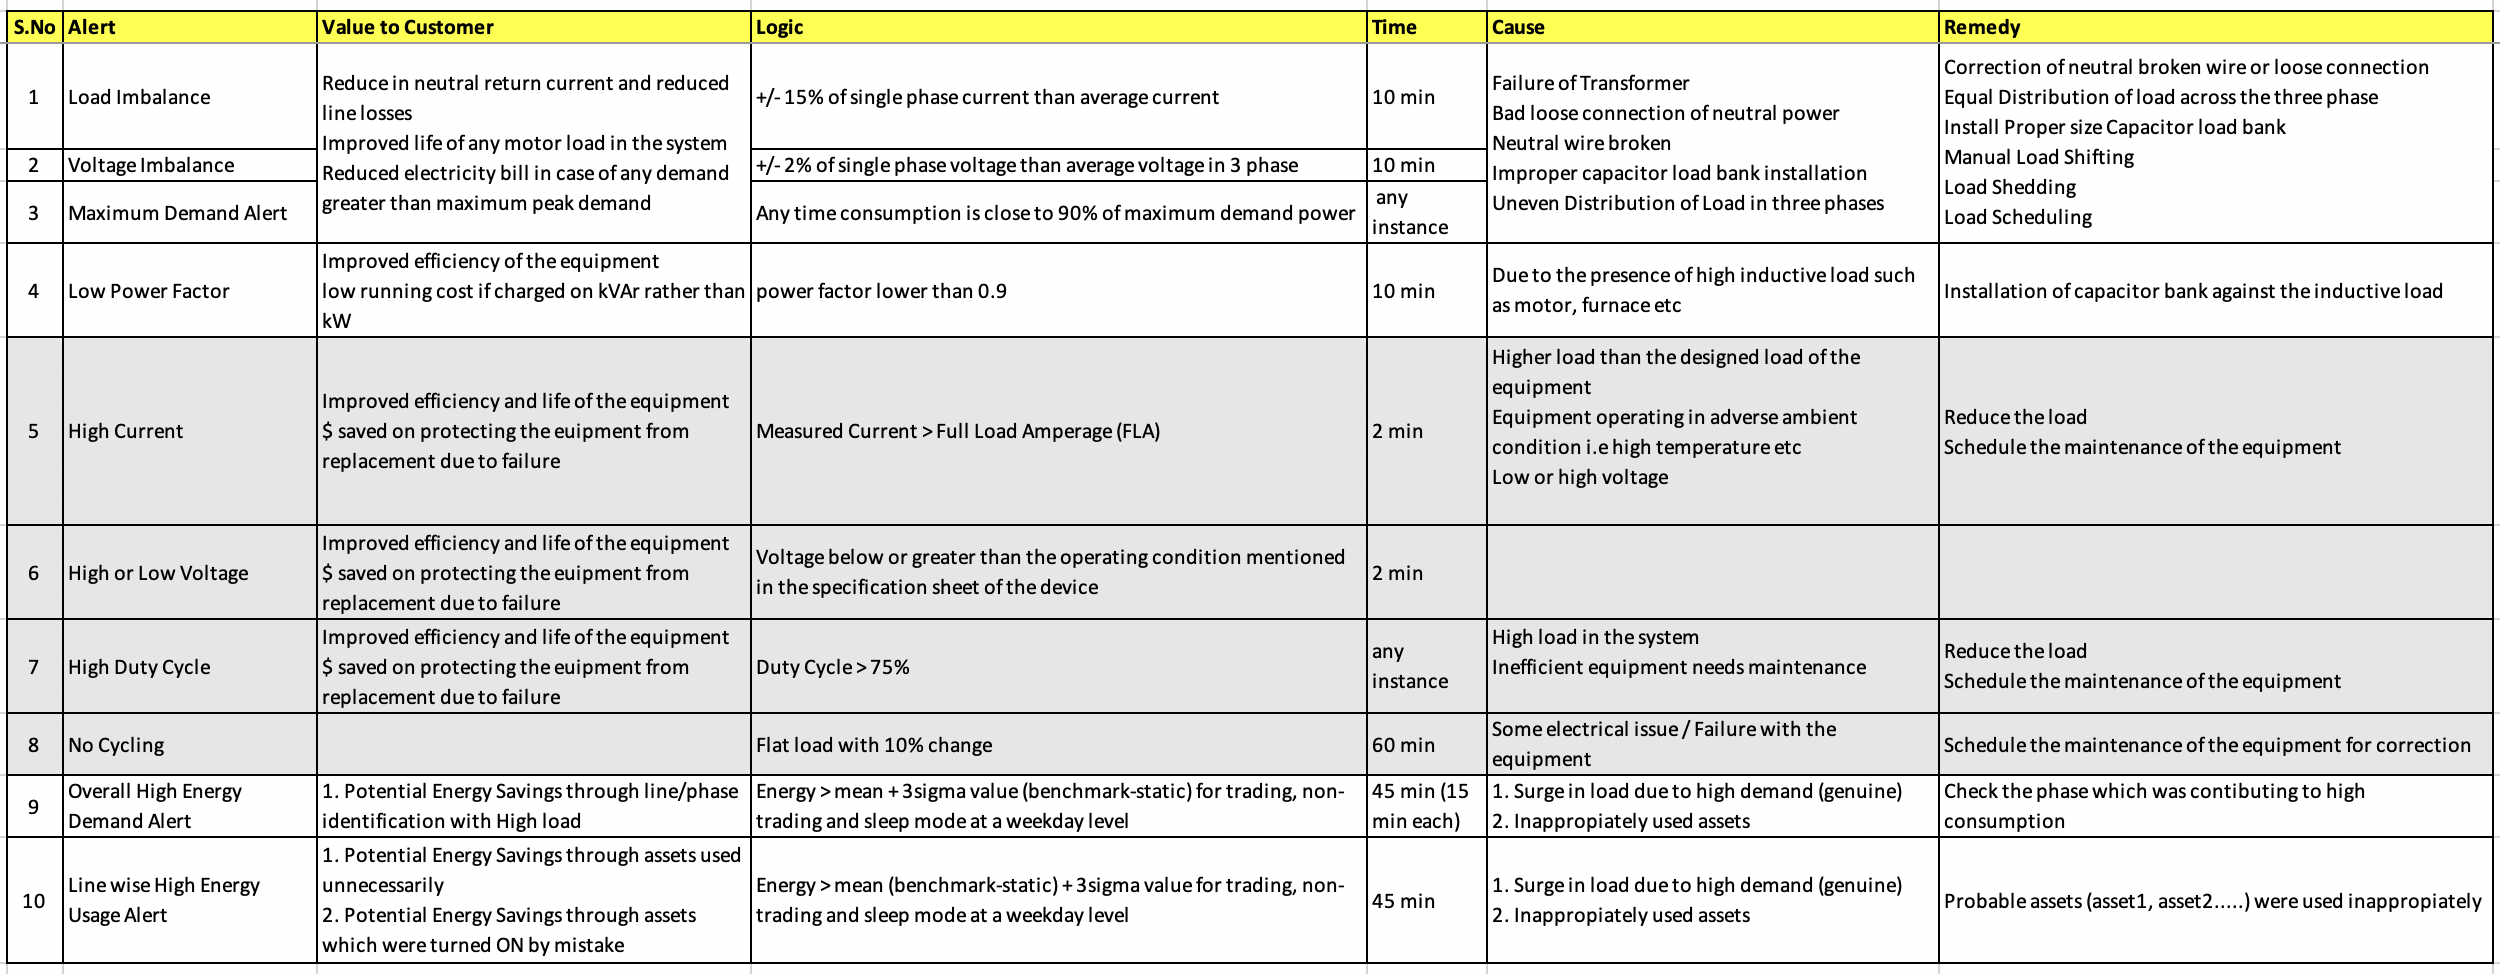

In [3]:
display(Markdown("# Configured alerts & their rules"))
import IPython 
IPython.display.Image("./image.png")

In [4]:
display(Markdown("# Alert Summary for Month of August"))
cm1 = sns.light_palette("red", as_cmap=True)
for col in final_alert_summary.columns:
    final_alert_summary[col]=final_alert_summary[col].astype(int)
final_alert_summary.rename(columns={'Abnormal Energy Consumption':'Abnormal Change in Energy Consumption'},inplace=True)
display(final_alert_summary.style.background_gradient(cmap=cm1))

# Alert Summary for Month of August

Alert Type,Abnormal Change in Energy Consumption,Load Imbalance,Low Power Factor
variable,,,
Main 1,8,0,60
Main 1 L1,14,1347,530
Main 1 L2,8,1435,75
Main 1 L3,6,590,0


In [5]:
run_interact()

# Alerts & Analytical Dashboard

interactive(children=(Dropdown(description='Select Parameter For Analysis', options=('Voltage Imbalance', 'Loa…

<function __main__.run_interact.<locals>.start_analysis(alert_analyse)>